Import libraries for data analysis

In [2]:
import os
import csv
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import scipy

Using TensorFlow backend.


Preprocess images to go from 364 images to 10,000 cropped, shifted, and zoomed images for testing.
1. Sort the images by number 
2. Match images with label (either cancerous or not cancerous)
3. Save 92 of 456 for evaluating the model at end (20%)
4. Crop, shift, and zoom on the images randomly to generate 10k examples

In [4]:
image_dir = '/input'
images = os.listdir(image_dir)
images.remove('ATTRIBUTION.txt')
images.remove('LICENSE.txt')
images.remove('.floyddata')
images = sorted(images, key=lambda x: int(x[-7:-4]))

In [28]:
X = []
y = []
cancer_count = 0
with open('ISIC-2017_Training_Part3_GroundTruth.csv', 'r') as csvfile:
    filereader = csv.reader(csvfile, delimiter=',')
    i = -1
    for row in filereader:
        if i != -1:      
            if i == len(images):
                break
            
            while (images[i].rstrip('.jpg') != row[0]):
                i += 1
                if i == len(images):
                    break

            if i == len(images):
                break
            
            if row[1] == '1.0':
                cancer_count += 1
                label = 'CANCER'
            else:
                label = 'NOT_CANCER'
            img = mpimg.imread('{}/{}'.format(image_dir, images[i]))
            img = scipy.misc.imresize(arr=img, size=(64, 64, 3))
            img_arr = np.asarray(img)
            X.append(img_arr)
            y.append(label)
    
        i += 1
X = np.asarray(X)
y = np.asarray(y)
print('cancer', cancer_count)
print('x', X.shape)
print('y', y.shape)

cancer 114
x (456, 64, 64, 3)
y (456,)


In [29]:
X_start, X_test, y_start, y_test = train_test_split(X, y, test_size = 0.15, random_state=0)
print('x_start', X_start.shape)
print('y_start', y_start.shape)
print('x_test', X_test.shape)

x_start (364, 64, 64, 3)
y_start (364,)
x_test (92, 64, 64, 3)


Augment_brightness, transform_image, and visualization of these transformations 
copied from Vivek Yadav's https://github.com/vxy10/ImageAugmentation

In [47]:
def augment_brightness(image):
    new_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = .833 + (np.random.uniform() / 3)
    new_image[:, :, 2] = new_image[:, :, 2]*random_bright
    new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2RGB)
    return new_image

def transform_image(img, ang_range, shear_range, trans_range, brightness=0):

    #  rotate
    ang_rot = np.random.uniform(ang_range) - ang_range / 2
    rows, cols, ch = img.shape
    Rot_M = cv2.getRotationMatrix2D((cols/2, rows/2), ang_rot, 1)

    #  translate
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])
    
    #shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
    pt1 = 5 + shear_range * np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range/2
    
    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])
    
    shear_M = cv2.getAffineTransform(pts1, pts2)
    
    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))
    
    if brightness == 1:
        img = augment_brightness(img)
        
    return img

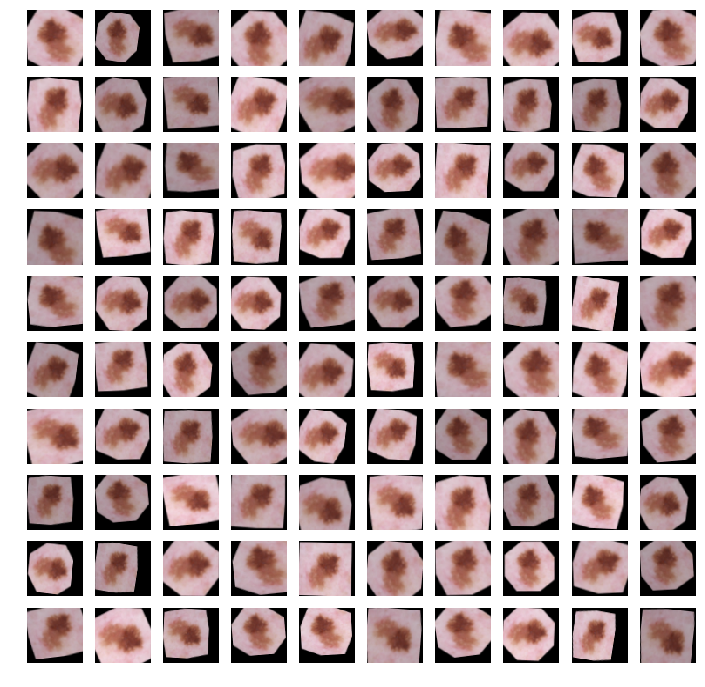

In [48]:
image = X_start[0]
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02)
plt.figure(figsize=(12, 12))
for i in range(100):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image, 180, 4, 5, brightness=1)
    
    plt.subplot(10, 10, i+1)
    plt.imshow(img)
    plt.axis('off')
    
plt.show()

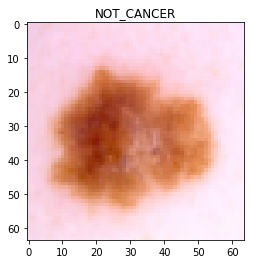

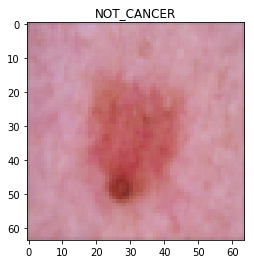

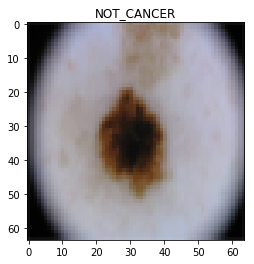

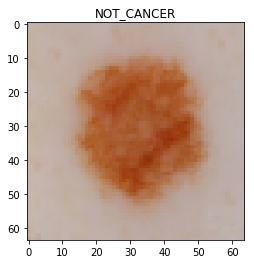

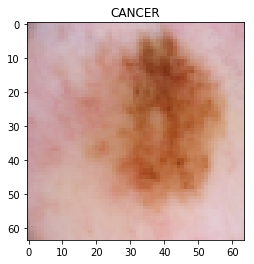

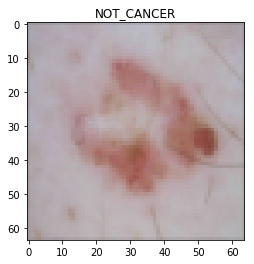

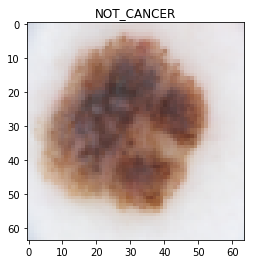

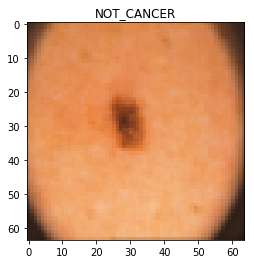

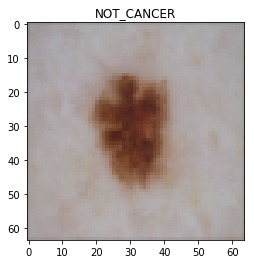

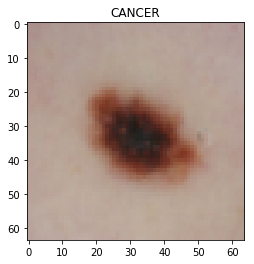

In [32]:
def show10():
    for i in range(0, 10):
        rand = random.randint(0, X_start.shape[0])
        img = X_start[rand]
        plt.imshow(img)
        plt.title(y_start[rand])
        plt.show()
        
show10()

In [49]:
new_X = []
new_y = []
for idx, (img, text) in enumerate(zip(X_start, y_start)):
    if text == 'CANCER':
        for i in range(0, 48):
            image = transform_image(img, 180, 4, 5, brightness=1)
            new_X.append(image)
            new_y.append(text)
    else:
        for i in range(0, 16):
            image = transform_image(img, 180, 4, 5, brightness=1)
            new_X.append(image)
            new_y.append(text)
            
new_X = np.asarray(new_X)
new_y = np.asarray(new_y)
print('x', new_X.shape)
print('y', new_y.shape)

x (8640, 64, 64, 3)
y (8640,)


In [50]:
epochs = 10
batch_size = 32

In [51]:
def make_model():
    model = Sequential()
    model.add(Lambda(lambda x: x * 1./ 255., input_shape=(64, 64, 3), output_shape=(64, 64, 3)))
    
    model.add(Conv2D(3, 1, 1, input_shape=(64, 64, 3)))

    model.add(Conv2D(12, 2, 2))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(24, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(.5))

#     model.add(Dense(10))
#     model.add(Activation('relu'))
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [52]:
model = make_model()
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_9 (Lambda)                (None, 64, 64, 3)     0           lambda_input_9[0][0]             
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 64, 3)     12          lambda_9[0][0]                   
____________________________________________________________________________________________________
convolution2d_28 (Convolution2D) (None, 63, 63, 12)    156         convolution2d_27[0][0]           
____________________________________________________________________________________________________
activation_39 (Activation)       (None, 63, 63, 12)    0           convolution2d_28[0][0]           
___________________________________________________________________________________________

In [53]:
X_train, y_train = new_X, new_y

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

print(y_train[:10])
print('xtrain', X_train.shape)

/usr/local/lib/python3.5/site-packages/numpy/lib/arraysetops.py:391: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


ValueError: y contains new labels: [0 1]

Train the model for 20 epochs, batch size 32, and save output weights.

In [54]:
model = make_model()

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    nb_epoch=epochs,
    shuffle=True,
    batch_size=batch_size)

model.save_weights('again.h5')

Train on 6912 samples, validate on 1728 samples
Epoch 1/10
6912/6912 [==============================] - 5s - loss: 0.6633 - acc: 0.5874 - val_loss: 0.6878 - val_acc: 0.5608

Evaluate the model on the 92 test images, and output the results

In [55]:
from sklearn.metrics import accuracy_score

y_pred = np.rint(model.predict(X_test))
print('prediction', accuracy_score(y_test, y_pred))

prediction 0.739130434783
